# Metrics

In [1]:
from utils import *
%load_ext autoreload
%autoreload 2

In [30]:
cfg = {
'EXPERIMENT': 'filter20_',
'DATASET': 'coco',
'MODEL': 'SAM',
'TARGET': 'SAM',
'SPARSITY': 40,
'CLASS': 0,
'MODE': '_gup',
'METRIC': 'iou'
}
cfg['ROOT'], cfg['N'], cfg['CLASSES'], cfg['SUPERCLASSES'], cfg['SUP_N'] = get_dataset_info(cfg['DATASET'])
cfg['SUP_L'] = {v: k for k, v in cfg['SUP_N'].items()}

## Compute Metrics

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload

In [ ]:
df_p = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")
df_0 = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_s = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [ ]:
df_0.head()

In [ ]:
# Add Image Shape
if 'shape' not in df_p.keys():
    df_p = add_image_shape(df_p, cfg)
    df_p.head()
    df_p.to_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")

In [ ]:
df_0s = get_analytics(df_0, df_s, df_p, cfg)
df_0s.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df_0s.head()

In [ ]:
df_0s.hist(column='class', bins=cfg['N'])
plt.semilogy()
plt.show()

In [ ]:
df_0s.hist(column='iou')
plt.semilogy()
plt.show()
df_0s['iou'].mean()

## Batch Save Analytics

In [ ]:
for s in range(10, 100, 10):
    cfg['SPARSITY'] = s
    save_analytics(cfg)

## Global Analytics

In [ ]:
# Save Summary
summary = []
for m in MODES:
    cfg['MODE'] = m
    for s in SPARSITIES:
        cfg['SPARSITY'] = s
        summary.append(get_summary(cfg))

cfg['MODE'] = ''
cfg['SPARSITY'] = 0
for n in MODELS[1:]:
    cfg['MODEL'] = n
    summary.append(get_summary(cfg))
summary = pd.concat(summary)
summary.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_summary.pkl")

In [ ]:
# Histograms
for t in METRICS:
    cfg['METRIC'] = t
    for m in MODES:
        cfg['MODE'] = m
        summary = []
        for s in SPARSITIES:
            cfg['SPARSITY'] = s
            summary.append(get_summary(cfg))
        summary = pd.concat(summary)
        get_hists(summary, cfg, save=True, plot=True)
plt.clf()

In [ ]:
cfg['MODE'] = ''
cfg['SPARSITY'] = 0
for t in METRICS:
    cfg['METRIC'] = t
    summary = []
    for n in MODELS[1:]:
        cfg['MODEL'] = n
        summary.append(get_summary(cfg))
    summary = pd.concat(summary)
    get_hists(summary, cfg, save=True, plot=True)
    plt.clf()

## Global Curves

In [ ]:
summary = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_summary.pkl")

for m in METRICS:
    cfg['METRIC'] = m
    get_curves(summary, cfg, std=False, plot=True, save=True)

## Class-wise Analytics

In [ ]:
# Save Summary
summary = []
for m in MODES:
    cfg['MODE'] = m
    for s in SPARSITIES:
        cfg['SPARSITY'] = s
        summary.append(get_summary(cfg, classwise=True))

cfg['MODE'] = ''
cfg['SPARSITY'] = 0
for n in MODELS[1:]:
    cfg['MODEL'] = n
    summary.append(get_summary(cfg, classwise=True))
summary = pd.concat(summary)
summary.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_classwise.pkl")

In [ ]:
d = summary[summary['pruning']=='_gup']
d = d[d['id']==50]
d = d[d['class']!=0]
get_hists(d, cfg, save=False, plot=True)

## Class-wise Curves

In [ ]:
summary = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_classwise.pkl")

In [ ]:
def get_classwise_curves(d, cfg, plot=True, save=False):
    _, ax = plt.subplots()
    ax.grid()
    ax.title.set_text(cfg['METRIC'].replace('_', ' ').capitalize())
    ax.plot(PARAMS['SAM'], SAM[cfg['METRIC']], 'o')
     
    for c in range(1, d.shape[1]):
        if cfg['MODEL'] == 'SAM':
            p = (1 - d[:,c,1]/100) * PARAMS['SAM'] 
        else:
            p = PARAMS[d[:,c,1][0]]
        ax.plot(p, d[:,c,2], '-o', label=f"{cfg['SUP_L'][c]} ({d[0,c,3]})")
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4, fontsize=9)   
    #plt.legend(loc='best', fontsize=9, ncol=2)
    plt.xlabel('Parameters')
    plt.ylabel(cfg['METRIC'].replace('_', ' ').capitalize())
    plt.axvline(PARAMS['SAM'], linestyle='--')
    plt.axhline(SAM[cfg['METRIC']], linestyle='--')
    plt.semilogx()
    if save:
        plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['METRIC']}_{cfg['MODEL']}{cfg['MODE']}_curves_classwise.pdf", bbox_inches='tight')
    if plot:
        plt.show()
    plt.clf()

In [ ]:
# GUP
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['pruning']=='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

# SparseGPT
cfg['MODE'] = '_gup'
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['id'].str.isalpha().isnull()]
    d = d[d['pruning']!='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

# FastSAM
# cfg['MODEL'] = 'FastSAM'
# for m in METRICS:
#     cfg['METRIC'] = m
#     d = summary[summary['id']==cfg['MODEL']][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
#     get_classwise_curves(d, cfg, plot=True, save=True)

# MobileSAM
# cfg['MODEL'] = 'MobileSAM'
# for m in METRICS:
#     cfg['METRIC'] = m
#     d = summary[summary['id']==cfg['MODEL']][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
#     get_classwise_curves(d, cfg, plot=True, save=True)

# Mobile&FastSAM
cfg['MODEL'] = 'Mobile&FastSAM'
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['id'].str.isalpha().notnull()][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

In [ ]:
def get_forgettability_curve_dissimilarity(d, cfg, plot=True, save=False):
    fcd = np.zeros((d.shape[1], d.shape[1]))
    for c1 in range(d.shape[1]):
        for c2 in range(c1, d.shape[1]):
            if c1 == c2:
                continue
            fcd[c1, c2] = ((d[:,c1,2] - d[:,c2,2])**2).mean()
            fcd[c2, c1] = fcd[c1, c2]

    plt.imshow(fcd, interpolation='nearest')
    plt.xticks(range(12), [cfg['SUP_L'][i] for i in range(1, 13)], rotation=90)
    plt.yticks(range(12), [cfg['SUP_L'][i] for i in range(1, 13)])
    plt.title('Forgettability Curve Dissimilarity - GUP')
    plt.colorbar()
    if save:
        plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}{cfg['MODE']}_fcd.pdf", bbox_inches='tight')
    if plot:
        plt.show()
    else:
        plt.clf()


In [ ]:
if cfg['MODE'] == '':
    # SparseGPT
    d = summary[summary['id'].str.isalpha().isnull()]
    d = d[d['pruning']!='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)[:,1:,:]
elif cfg['MODE'] == '_gup':
    # GUP
    d = summary[summary['pruning']=='_gup'][['class', 'id', cfg['METRIC']]].values.reshape(9, 13, -1)[:,1:,:]

In [ ]:
get_forgettability_curve_dissimilarity(d, cfg, plot=True, save=True)

## Cluster Analytics

In [31]:
df = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity,superclass,cluster
0,139,"[452, 206]",1,"[0, 1]",[1],0.710596,-0.273627,0.006507,0.361124,0.594164,0.997194,0.745424,0.631342,0.909829,0.997590,1,1
1,285,"[568, 514]",23,"[0, 23]","[0, 23]",0.729454,-0.281743,0.013036,-0.980993,0.016901,0.274435,0.033240,0.956842,0.016914,0.997857,4,2
2,632,"[519, 266]",84,"[0, 84]","[0, 84]",0.705488,-0.246925,0.018346,0.323879,0.737425,0.995170,0.848871,0.739376,0.996435,0.995153,12,1
3,724,"[125, 286]",8,"[0, 8]","[0, 8]",0.734146,-0.218788,0.000981,-0.387469,0.439141,0.998747,0.610282,1.000000,0.439141,1.000000,2,2
4,776,"[36, 67]",65,"[0, 65]",[65],0.802722,-0.202490,0.040680,0.259740,0.778690,0.990946,0.875577,0.783093,0.992832,0.990884,9,1


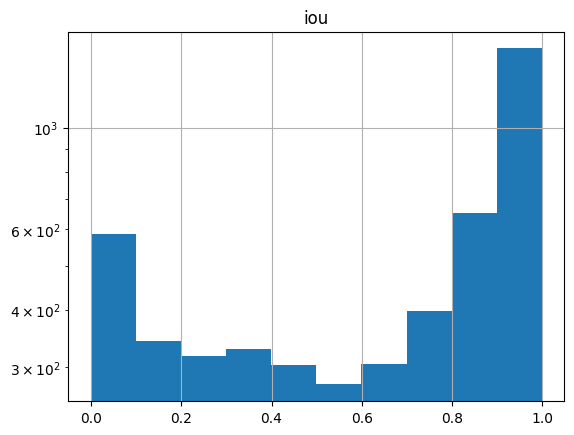

In [32]:
df.hist(column='iou')
plt.semilogy()
plt.show()

In [33]:
df = add_superclass(df, cfg)

In [34]:
features = ['iou', 'precision', 'recall', 'mask_size', 'mask_size_diff', 'superclass']
data = df[features].values

In [35]:
df['cluster'] = get_clusters(data, cfg, plot=False, save=False)
df.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

#: 3; # samples: 5000; # features 6


<Figure size 640x480 with 0 Axes>

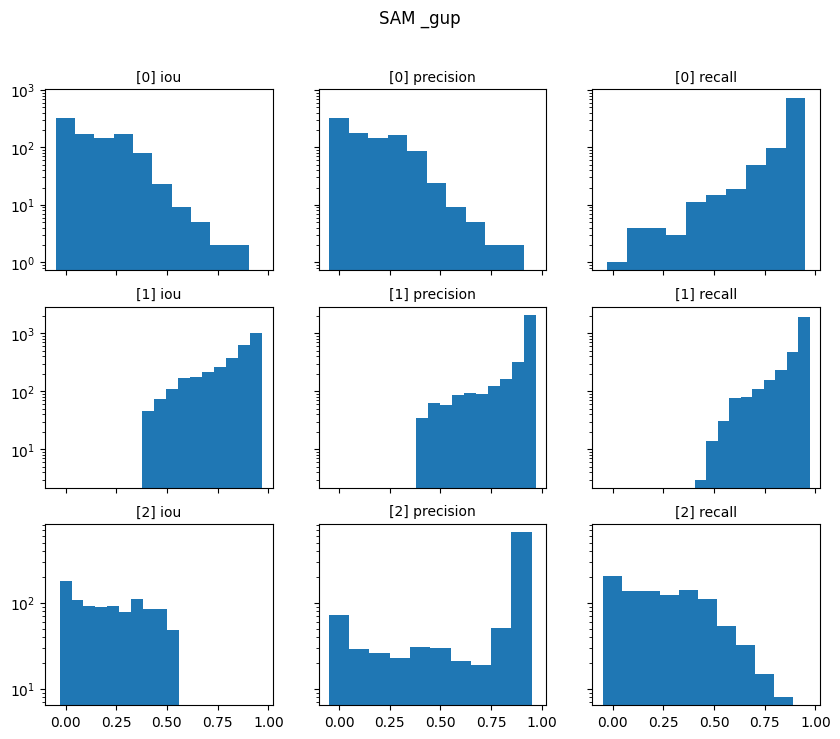

In [36]:
from itertools import product
def prod(l1, l2):
   return list(product(l1, l2))

M = ['iou', 'precision', 'recall']

fig, axs = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(10,8))
for (ax, (c,m)) in zip(axs.flat, prod(range(3), M)):
    y, x = np.histogram(df[df['cluster']==c][m])
    ax.bar(x[:-1], y, width=x[1]-x[0], alpha=1)
    ax.set_title(f"[{c}] {m}", fontsize=10)
    ax.semilogy()
plt.suptitle(f"{cfg['MODEL']} {cfg['MODE']}", fontsize=12)
plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}_clusters.pdf", bbox_inches='tight')
plt.show()

## CIEs

 **ID**       |**0**|**1**|**2**|
--------------|-----|-----|-----|
*SAM_40gup_20*|R    |IoU  |P    |
*SAM_80_20*   |P    |R    |IoU  |
*MobileSAM_20*|IoU  |R    |P    |
*FastSAM_20*  |R    |IoU  |P    |

In [ ]:
df = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df_0 = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_s = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [ ]:
C = 2
N = int(0.05*len(df))
df_c = df[df['cluster']==C]
min_iou = df_c.nsmallest(N, ['iou'])

In [ ]:
show_samples(pie_df=min_iou, target_df=df_0, pred_df=df_s, cfg=cfg, prompt_zoom=False, n=5, random=True, save=False)

# Test